In [1]:
# Import libraries!
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Model

In [2]:
# Helper for time-regulated production
def pulse_input(t, t_on, t_off, rate):
    if t_on <= t <= t_off:
        return rate
    else:
        return 0.0

# ODE model (dynamic L and R2)
def model(states, t,
          L_on, L_off, L_rate,
          R2_on, R2_off, R2_rate,
          k_a, k_b,       # R1 + L <-> R1L
          k_c, k_d,       # pr_a + R1 <-> pr_R1
          k_e, k_f,       # pr_a + R2 <-> pr_R2
          k_deg1,         # G degradation
          k_deg2,         # R2 degradation
          k_deg3,         # R1 and R1L degradation
          k_syn):         # G synthesis from pr_a
    """
    states = [R1, pr_a, pr_R1, pr_R2, R1L, G, L, R2]
    """

    R1, pr_a, pr_R1, pr_R2, R1L, G, L, R2 = states

    # Time-regulated production rates
    u_L  = pulse_input(t,  L_on,  L_off,  L_rate)
    u_R2 = pulse_input(t, R2_on, R2_off, R2_rate)

    # R1 dynamics: binds L, binds promoter, degrades
    R1_prime = (
        - k_a * R1 * L      # bind L -> R1L
        + k_b * R1L         # unbind L
        + k_deg3 * R1L       # degrade R1L to free R1
        - k_c * pr_a * R1   # bind promoter
        + k_d * pr_R1       # unbind promoter
    )

    # R1L complex dynamics
    R1L_prime = (
        + k_a * R1 * L      # form complex
        - k_b * R1L         # dissociate
        - k_deg3 * R1L      # degrade complex
    )

    # Ligand L dynamics
    L_prime = (
        + u_L               # time-regulated production
        - k_a * R1 * L      # bind R1
        + k_b * R1L         # unbind
        - k_deg3 * L        # degrade free L
        - k_deg3 * R1L      # degrade bound L
    )

    # Promoter states
    pr_a_prime = (
        - k_c * pr_a * R1   # bind R1
        + k_d * pr_R1       # unbind R1
        - k_e * pr_a * R2   # bind R2
        + k_f * pr_R2       # unbind R2
    )

    pr_R1_prime = (
        + k_c * pr_a * R1   # bind
        - k_d * pr_R1       # unbind
    )

    pr_R2_prime = (
        + k_e * pr_a * R2   # bind
        - k_f * pr_R2       # unbind
    )

    # R2 dynamics (real species now)
    R2_prime = (
        + u_R2              # time-regulated production
        - k_e * pr_a * R2   # bind promoter
        + k_f * pr_R2       # unbind promoter
        - k_deg2 * R2       # degrade free R2
    )

    # Gene product G
    G_prime = k_syn * pr_a - k_deg1 * G

    return [R1_prime, pr_a_prime, pr_R1_prime, pr_R2_prime,
            R1L_prime, G_prime, L_prime, R2_prime]


In [4]:
#Simulation of Model

#initial conditions
R1_0   = 1.0
pr_a_0 = 1.0   # all promoter active initially
pr_R1_0 = 0.0
pr_R2_0 = 0.0
R1L_0  = 0.0
G_0    = 0.0
L_0    = 0.0
R2_0   = 0.0

states0 = [R1_0, pr_a_0, pr_R1_0, pr_R2_0, R1L_0, G_0, L_0, R2_0]

#parameters
k_a = 0.05
k_b = 0.10
k_c = 0.50
k_d = 0.30
k_e = 0.50
k_f = 0.30
k_deg1 = 0.02
k_deg2 = 0.05
k_deg3 = 0.02
k_syn  = 0.50

#L and R2 production pulses
L_on_time   = 20.0
L_off_time  = 80.0
R2_on_time  = 40.0
R2_off_time = 100.0
L_prod_rate  = 0.2   # u_L(t) during pulse
R2_prod_rate = 0.1   # u_R2(t) during pulse

# ---- simulate over 0–150 min ----
t_final = np.linspace(0, 150, 1001)

solution = odeint(
    model, states0, t_final,
    args=(L_on_time, L_off_time, L_prod_rate,
          R2_on_time, R2_off_time, R2_prod_rate,
          k_a, k_b,
          k_c, k_d,
          k_e, k_f,
          k_deg1, k_deg2, k_deg3,
          k_syn)
)

# solution columns: [R1, pr_a, pr_R1, pr_R2, R1L, G, L, R2]
R1   = solution[:,0]
pr_a = solution[:,1]
G    = solution[:,5]
L    = solution[:,6]
R2   = solution[:,7]

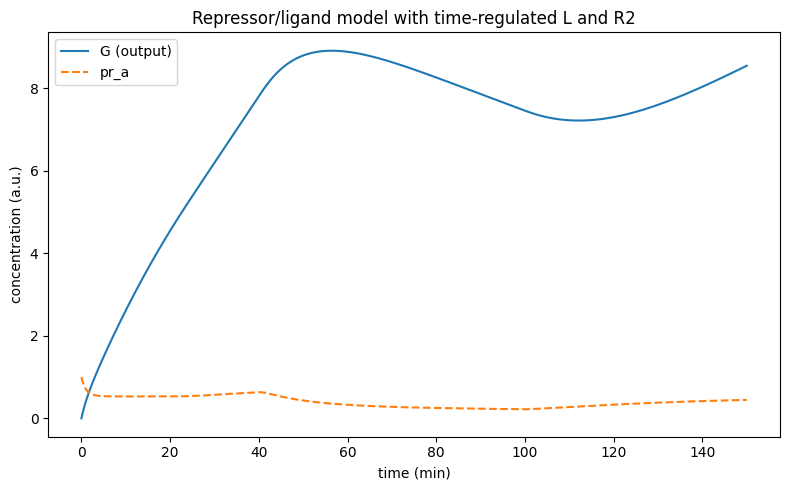

In [5]:
# Plot the output and promoter activity
plt.figure(figsize=(8,5))
plt.plot(t_final, G, label="G (output)")
plt.plot(t_final, pr_a, "--", label="pr_a")
plt.xlabel("time (min)")
plt.ylabel("concentration (a.u.)")
plt.legend()
plt.title("Repressor/ligand model with time-regulated L and R2")
plt.tight_layout()
plt.show()